# Lab 1 - Análisis de Movimiento Armónico Simple (MAS)

Notebook para análisis de datos de movimiento armónico simple usando datos de Vernier.

**Características:**
- Ajuste de curvas con modelo MAS
- Análisis de Transformada de Fourier (FFT)
- Visualización de cinemática y espacio de fase
- Identificación de armónicos

## 1. Instalación de Dependencias

En Google Colab, las bibliotecas principales ya están instaladas. Si necesitas ejecutar este notebook localmente, asegúrate de instalar las dependencias del archivo `requirements.txt`.

In [1]:
# Verificar versiones de las bibliotecas instaladas
import pandas as pd
import numpy as np
import matplotlib
import scipy

print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"scipy: {scipy.__version__}")

pandas: 3.0.0
numpy: 2.4.1
matplotlib: 3.10.8
scipy: 1.17.0


## 2. Importación de Bibliotecas

Importamos todas las bibliotecas necesarias para el análisis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
import os

print("✓ Todas las bibliotecas importadas correctamente")

✓ Todas las bibliotecas importadas correctamente


## 3. Configuración de Archivos

Define los archivos de datos a procesar.

**Para Google Colab:** Descomenta la celda siguiente para subir los archivos desde tu computadora.

In [3]:
# Para Google Colab: Descomentar para subir archivos
# from google.colab import files
# uploaded = files.upload()

# Lista de archivos a procesar
FILES = ["10Hz.txt", "20Hz.txt", "30Hz.txt"]

print(f"Archivos configurados: {FILES}")

Archivos configurados: ['10Hz.txt', '20Hz.txt', '30Hz.txt']


## 4. Función de Carga de Datos

Esta función lee los archivos de texto generados por Vernier y los procesa en un DataFrame de pandas.

In [4]:
def load_data(filename):
    """Carga datos saltando encabezados y renombrando columnas según Vernier."""
    if not os.path.exists(filename):
        print(f"[AVISO] El archivo '{filename}' no existe en la carpeta. Se omite.")
        return None

    try:
        # Vernier suele tener metadatos en las primeras 6 líneas aprox.
        df = pd.read_csv(filename, sep="\t", skiprows=6)

        # Renombrar columnas (Basado en el estándar de Logger Pro para esta práctica)
        # Se asume el orden: t, Pot, I, Angulo, VelAng, AcelAng, Pos, VelLin, AcelLin
        # Si tus archivos tienen otro orden, ajusta esta lista.
        cols_std = ["t", "Pot", "I", "theta", "w", "alpha", "x", "v", "a"]

        # Ajustamos las columnas detectadas a nuestros nombres
        current_cols = df.columns.tolist()
        if len(current_cols) >= len(cols_std):
            mapper = {current_cols[i]: cols_std[i] for i in range(len(cols_std))}
            df = df.rename(columns=mapper)
            # Seleccionamos solo las que nos interesan
            df = df[cols_std]

        df = df.dropna()
        return df
    except Exception as e:
        print(f"[ERROR] Falló la lectura de '{filename}': {e}")
        return None

print("✓ Función load_data() definida")

✓ Función load_data() definida


## 5. Modelos Matemáticos del MAS

Definimos los modelos matemáticos del Movimiento Armónico Simple para posición, velocidad y aceleración:

**Posición:** $$x(t) = A_0 + A \cos(\omega t + \phi)$$

**Velocidad:** $$v(t) = -\omega A \sin(\omega t + \phi)$$

**Aceleración:** $$a(t) = -\omega^2 A \cos(\omega t + \phi)$$

Donde:
- $A_0$ es la posición de equilibrio
- $A$ es la amplitud
- $\omega$ es la frecuencia angular
- $\phi$ es la fase inicial

In [5]:
def mas_pos(t, A0, A, w, phi):
    """Modelo MAS para Posición: x(t) = A0 + A*cos(w*t + phi)"""
    return A0 + A * np.cos(w * t + phi)


def mas_vel(t, A, w, phi):
    """Modelo MAS para Velocidad (derivada de x): v(t) = -w*A*sin(w*t + phi)"""
    return -w * A * np.sin(w * t + phi)


def mas_acel(t, A, w, phi):
    """Modelo MAS para Aceleración (derivada de v): a(t) = -w^2*A*cos(w*t + phi)"""
    return -(w**2) * A * np.cos(w * t + phi)


def reconstruccion_armonica(t, params_armonicos):
    """
    Reconstruye la señal sumando cosenos:
    a_approx(t) = Sum( Ai * cos(2*pi*fi*t + phii) )
    """
    senal = np.zeros_like(t)
    for f, A, phi in params_armonicos:
        senal += A * np.cos(2 * np.pi * f * t + phi)
    return senal

print("✓ Funciones del modelo MAS definidas")

✓ Funciones del modelo MAS definidas


## 6. Función de Procesamiento

Función optimizada que procesa los datos y retorna resultados para análisis comparativo.

In [6]:
def process_file(filename):
    """Procesa un archivo y retorna datos para análisis comparativo."""
    df = load_data(filename)
    if df is None:
        return None
    # --- CAMBIO 1: ACOTAR LOS DATOS ---
    # Esto elige solo del segundo 3 al 8. Cámbialo según tus gráficas.
    df = df[(df['t'] >= 3) & (df['t'] <= 13)]

    # Extraer variables
    t = df["t"].values
    theta = df["theta"].values
    w_ang = df["w"].values
    alpha = df["alpha"].values
    x = df["x"].values
    v = df["v"].values
    a = df["a"].values

    # Ajuste MAS
    A0_guess = np.mean(x)
    A_guess = (np.max(x) - np.min(x)) / 2
    w_guess = np.abs(np.mean(w_ang)) if len(w_ang) > 0 else 2 * np.pi

    try:
        popt, _ = curve_fit(mas_pos, t, x, p0=[A0_guess, A_guess, w_guess, 0], maxfev=10000)
        A0_fit, A_fit, w_fit, phi_fit = popt
        x_model = mas_pos(t, A0_fit, A_fit, w_fit, phi_fit)
        v_model = mas_vel(t, A_fit, w_fit, phi_fit)
        a_model = mas_acel(t, A_fit, w_fit, phi_fit)
    except:
        A0_fit = A_fit = w_fit = phi_fit = 0
        x_model = v_model = a_model = np.zeros_like(x)

    # Análisis FFT
    N = len(a)
    dt = np.mean(np.diff(t))
    yf = fft(a)
    xf = fftfreq(N, dt)[: N // 2]
    amplitudes = 2.0 / N * np.abs(yf[0 : N // 2])
    phases = np.angle(yf[0 : N // 2])

    # Encontrar armónicos
    # --- CAMBIO 2: LÓGICA DE ARMÓNICOS ---
    # 1. Encontramos el primer armónico (el más alto)
    idx_f1 = np.argmax(amplitudes[1:]) + 1 # +1 porque saltamos el índice 0 (DC)
    f1 = xf[idx_f1]

    # 2. Buscamos el segundo armónico cerca del doble de f1 (entre 1.8 y 2.2 veces f1)
    rango_f2 = (xf > 1.8 * f1) & (xf < 2.2 * f1)
    if np.any(rango_f2):
        # De los que están en ese rango, elegimos el más alto
        indices_rango = np.where(rango_f2)[0]
        idx_f2 = indices_rango[np.argmax(amplitudes[indices_rango])]
    else:
        # Si no lo encuentra, toma el segundo más alto de toda la señal
        amp_search = amplitudes.copy()
        amp_search[0] = 0
        amp_search[idx_f1] = 0
        idx_f2 = np.argmax(amp_search)

    idx_peaks = sorted([idx_f1, idx_f2])

    armonicos_data = []
    for idx in idx_peaks:
        armonicos_data.append((xf[idx], amplitudes[idx], phases[idx]))

    # Reconstrucción
    a_reconst = reconstruccion_armonica(t, armonicos_data)
    correlacion = np.corrcoef(a, a_reconst)[0, 1]

    # Ajuste x(theta)
    try:
        def x_theta_model(theta, A0, A, phi):
            return A0 + A * np.cos(theta + phi)

        popt_theta, _ = curve_fit(x_theta_model, theta, x,
                                   p0=[np.mean(x), (np.max(x) - np.min(x)) / 2, 0],
                                   maxfev=10000)
        x_theta_fit = x_theta_model(theta, *popt_theta)
        error_rms_theta = np.sqrt(np.mean((x - x_theta_fit)**2))
    except:
        x_theta_fit = None
        error_rms_theta = None

    return {
        't': t, 'theta': theta, 'w_ang': w_ang, 'alpha': alpha,
        'x': x, 'v': v, 'a': a,
        'x_model': x_model, 'v_model': v_model, 'a_model': a_model,
        'A0': A0_fit, 'A': A_fit, 'w': w_fit, 'phi': phi_fit,
        'xf': xf, 'amplitudes': amplitudes, 'idx_peaks': idx_peaks,
        'armonicos': armonicos_data, 'a_reconst': a_reconst, 'correlacion': correlacion,
        'x_theta_fit': x_theta_fit, 'error_rms_theta': error_rms_theta
    }

print("✓ Función process_file() definida")

✓ Función process_file() definida


## 7. Procesamiento de Datos

Carga y procesa todos los archivos de datos.

In [7]:
# Procesar todos los archivos
resultados = {}
for archivo in FILES:
    print(f"Procesando {archivo}...")
    resultado = process_file(archivo)
    if resultado:
        resultados[archivo] = resultado
        print(f"  ✓ Completado")

print(f"\n✓ {len(resultados)} archivos procesados correctamente")

Procesando 10Hz.txt...
  ✓ Completado
Procesando 20Hz.txt...
  ✓ Completado
Procesando 30Hz.txt...
  ✓ Completado

✓ 3 archivos procesados correctamente


## 8. Análisis del Movimiento Angular

Gráficas de θ, ω y α vs tiempo para cada frecuencia de muestreo.

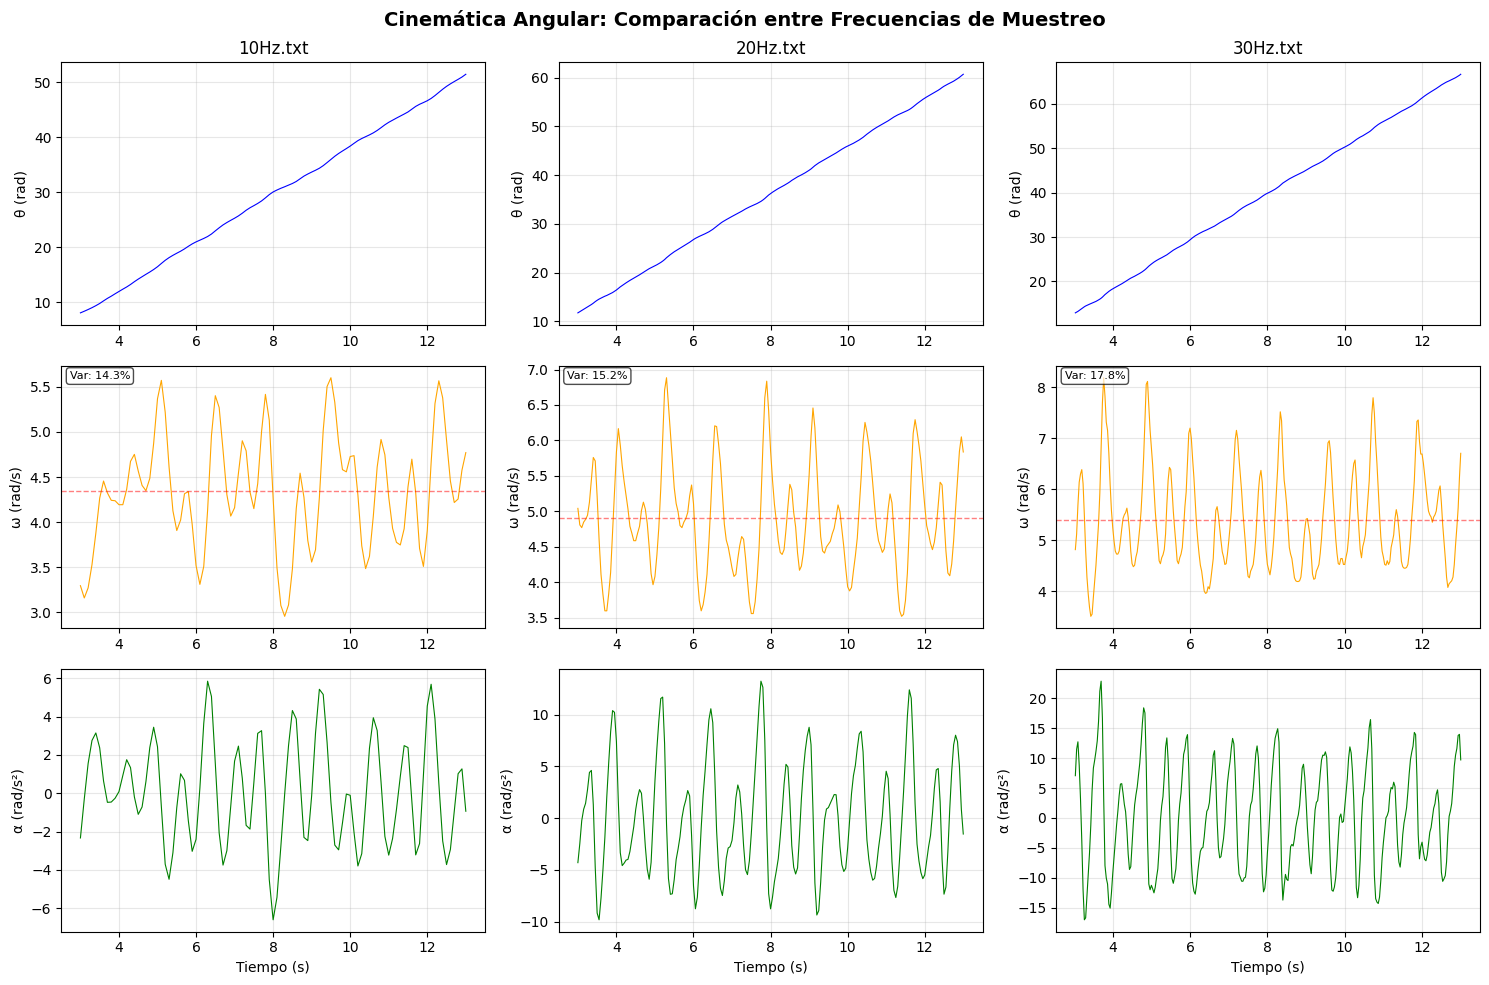

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Cinemática Angular: Comparación entre Frecuencias de Muestreo', fontsize=14, fontweight='bold')

for i, (archivo, datos) in enumerate(resultados.items()):
    # Ángulo
    axes[0, i].plot(datos['t'], datos['theta'], 'b-', linewidth=0.8)
    axes[0, i].set_ylabel('θ (rad)')
    axes[0, i].set_title(archivo)
    axes[0, i].grid(True, alpha=0.3)

    # Velocidad angular
    axes[1, i].plot(datos['t'], datos['w_ang'], 'orange', linewidth=0.8)
    axes[1, i].set_ylabel('ω (rad/s)')
    axes[1, i].grid(True, alpha=0.3)

    # Análisis MCU
    w_mean = np.mean(datos['w_ang'])
    w_std = np.std(datos['w_ang'])
    var_pct = (w_std / abs(w_mean)) * 100 if w_mean != 0 else 0
    axes[1, i].axhline(y=w_mean, color='r', linestyle='--', linewidth=1, alpha=0.5)
    axes[1, i].text(0.02, 0.98, f'Var: {var_pct:.1f}%', transform=axes[1, i].transAxes,
                    va='top', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Aceleración angular
    axes[2, i].plot(datos['t'], datos['alpha'], 'g-', linewidth=0.8)
    axes[2, i].set_ylabel('α (rad/s²)')
    axes[2, i].set_xlabel('Tiempo (s)')
    axes[2, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Análisis de MCU y Aceleración Angular

Evaluación del Movimiento Circular Uniforme mediante análisis de la velocidad angular y distribución de aceleraciones.

## 9. Ajuste MAS: Cinemática Lineal

Comparación de datos experimentales con modelo MAS para posición, velocidad y aceleración.

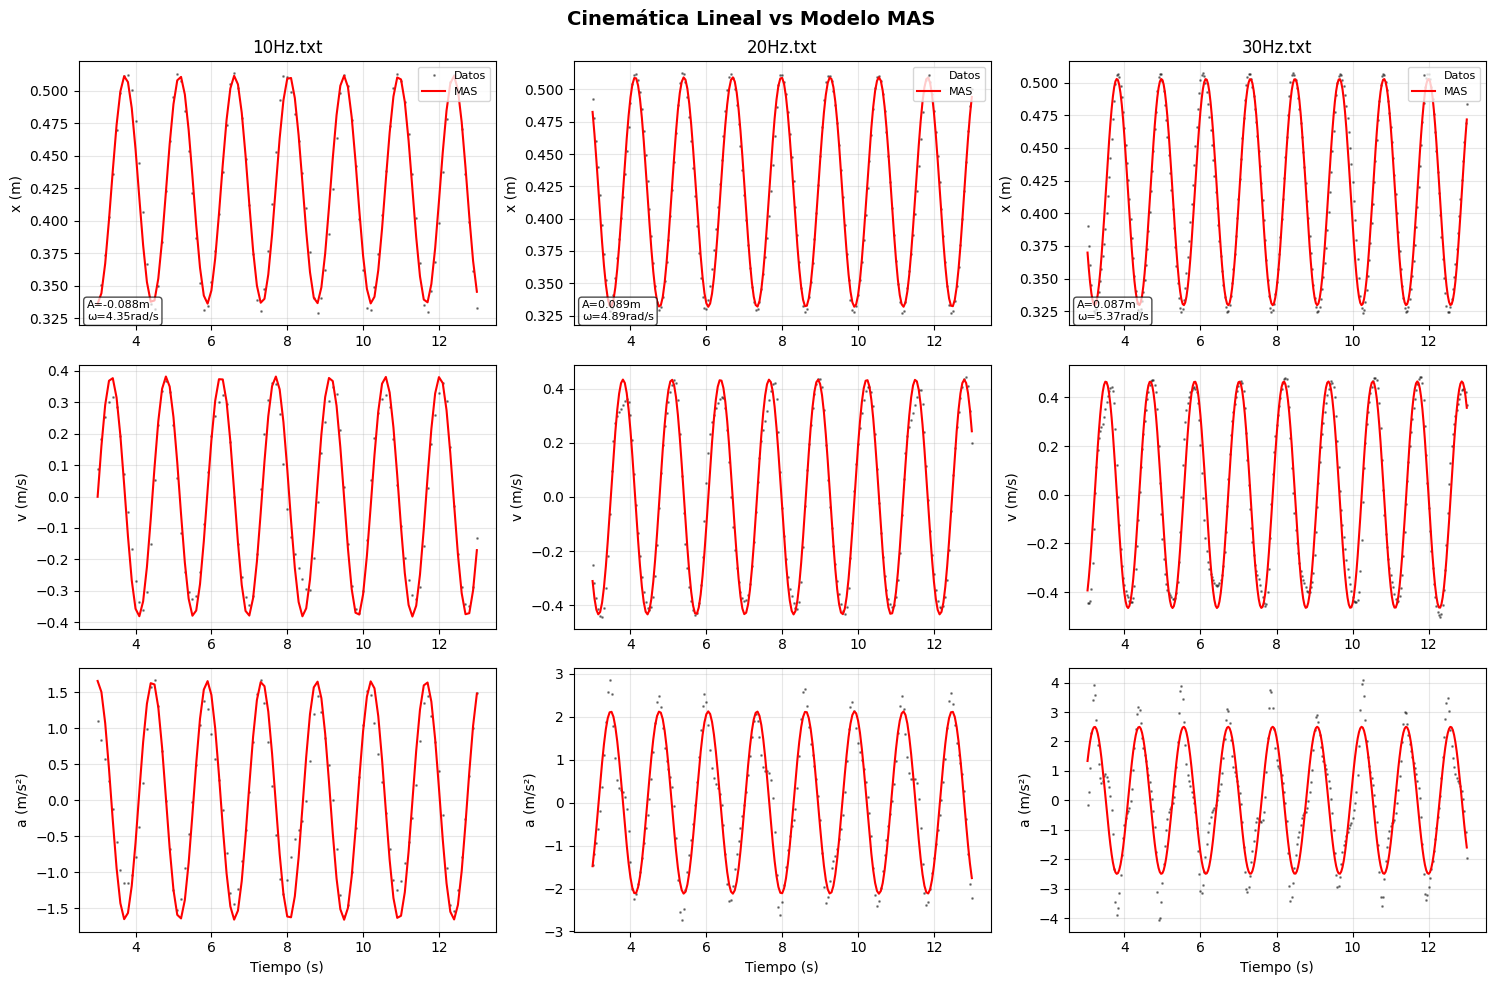

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
fig.suptitle('Cinemática Lineal vs Modelo MAS', fontsize=14, fontweight='bold')

for i, (archivo, datos) in enumerate(resultados.items()):
    # Posición
    axes[0, i].plot(datos['t'], datos['x'], 'k.', markersize=2, alpha=0.4, label='Datos')
    axes[0, i].plot(datos['t'], datos['x_model'], 'r-', linewidth=1.5, label='MAS')
    axes[0, i].set_ylabel('x (m)')
    axes[0, i].set_title(archivo)
    axes[0, i].legend(fontsize=8, loc='upper right')
    axes[0, i].grid(True, alpha=0.3)

    # Velocidad
    axes[1, i].plot(datos['t'], datos['v'], 'k.', markersize=2, alpha=0.4)
    axes[1, i].plot(datos['t'], datos['v_model'], 'r-', linewidth=1.5)
    axes[1, i].set_ylabel('v (m/s)')
    axes[1, i].grid(True, alpha=0.3)

    # Aceleración
    axes[2, i].plot(datos['t'], datos['a'], 'k.', markersize=2, alpha=0.4)
    axes[2, i].plot(datos['t'], datos['a_model'], 'r-', linewidth=1.5)
    axes[2, i].set_ylabel('a (m/s²)')
    axes[2, i].set_xlabel('Tiempo (s)')
    axes[2, i].grid(True, alpha=0.3)

    # Mostrar parámetros del ajuste
    params_text = f'A={datos["A"]:.3f}m\nω={datos["w"]:.2f}rad/s'
    axes[0, i].text(0.02, 0.02, params_text, transform=axes[0, i].transAxes,
                    fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

## 10. Espacio de Fase: x vs θ

Análisis de asimetrías y ajuste sinusoidal de la posición en función del ángulo.

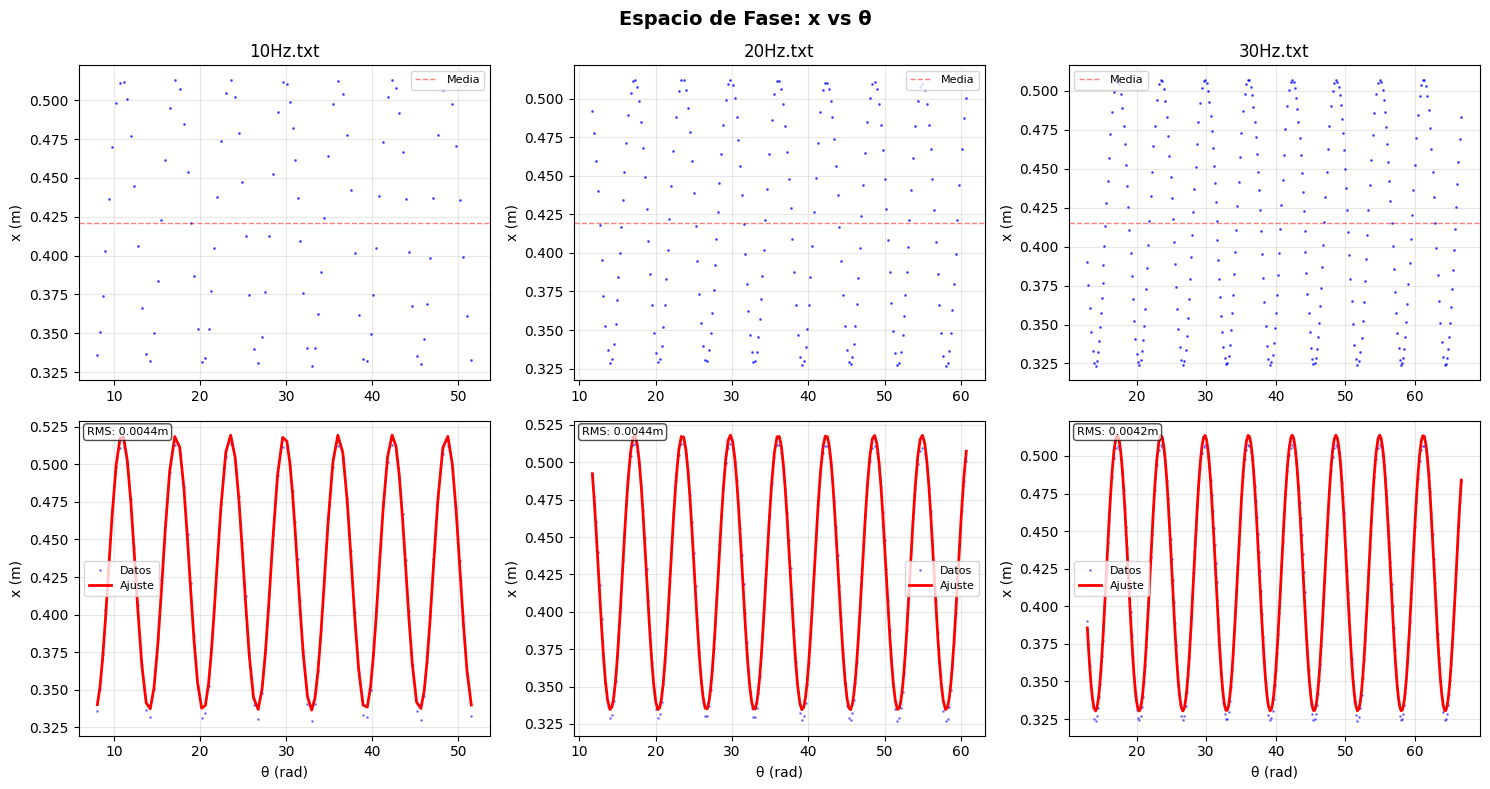

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Espacio de Fase: x vs θ', fontsize=14, fontweight='bold')

for i, (archivo, datos) in enumerate(resultados.items()):
    # Gráfica x vs theta
    axes[0, i].plot(datos['theta'], datos['x'], 'b.', markersize=2, alpha=0.6)
    x_medio = (np.max(datos['x']) + np.min(datos['x'])) / 2
    axes[0, i].axhline(y=x_medio, color='r', linestyle='--', linewidth=1, alpha=0.5, label='Media')
    axes[0, i].set_ylabel('x (m)')
    axes[0, i].set_title(archivo)
    axes[0, i].legend(fontsize=8)
    axes[0, i].grid(True, alpha=0.3)

    # Ajuste sinusoidal
    if datos['x_theta_fit'] is not None:
        axes[1, i].plot(datos['theta'], datos['x'], 'b.', markersize=2, alpha=0.4, label='Datos')
        axes[1, i].plot(datos['theta'], datos['x_theta_fit'], 'r-', linewidth=2, label='Ajuste')
        axes[1, i].set_xlabel('θ (rad)')
        axes[1, i].set_ylabel('x (m)')
        axes[1, i].legend(fontsize=8)
        axes[1, i].grid(True, alpha=0.3)

        # Mostrar error
        error_text = f'RMS: {datos["error_rms_theta"]:.4f}m'
        axes[1, i].text(0.02, 0.98, error_text, transform=axes[1, i].transAxes,
                        va='top', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    else:
        axes[1, i].text(0.5, 0.5, 'Ajuste no disponible', ha='center', va='center',
                        transform=axes[1, i].transAxes)

plt.tight_layout()
plt.show()

### Interpretación Física de x(θ)

Análisis de asimetrías y explicación geométrica de las desviaciones del comportamiento sinusoidal.

## 11. Análisis Espectral (DFT)

Espectro de frecuencias y armónicos dominantes de la aceleración.

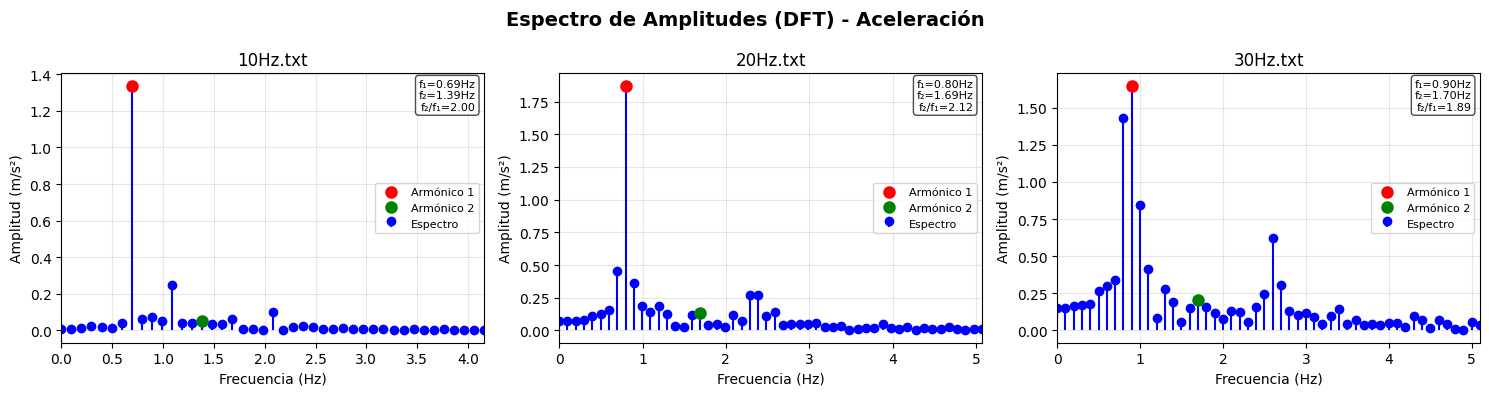

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Espectro de Amplitudes (DFT) - Aceleración', fontsize=14, fontweight='bold')

for i, (archivo, datos) in enumerate(resultados.items()):
    axes[i].stem(datos['xf'], datos['amplitudes'], basefmt=" ", linefmt="b-", markerfmt='bo',
                 label='Espectro')

    # Marcar armónicos
    colores = ['r', 'g']
    for j, idx in enumerate(datos['idx_peaks']):
        axes[i].plot(datos['xf'][idx], datos['amplitudes'][idx], 'o',
                     color=colores[j], markersize=8, label=f'Armónico {j+1}')

    # Zoom dinámico
    if len(datos['idx_peaks']) > 0:
        max_freq = datos['xf'][datos['idx_peaks'][-1]]
        axes[i].set_xlim(0, max_freq * 3)

    axes[i].set_xlabel('Frecuencia (Hz)')
    axes[i].set_ylabel('Amplitud (m/s²)')
    axes[i].set_title(archivo)
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

    # Mostrar relación de frecuencias
    if len(datos['armonicos']) >= 2:
        f1 = datos['armonicos'][0][0]
        f2 = datos['armonicos'][1][0]
        relacion = f2 / f1 if f1 != 0 else 0
        text = f'f₁={f1:.2f}Hz\nf₂={f2:.2f}Hz\nf₂/f₁={relacion:.2f}'
        axes[i].text(0.98, 0.98, text, transform=axes[i].transAxes, ha='right', va='top',
                     fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

### Análisis Detallado del Espectro

Identificación de armónicos adicionales y posibles causas físicas.

## 12. Reconstrucción de Señal con Armónicos

Comparación de la señal original vs reconstrucción usando solo los 2 armónicos principales.

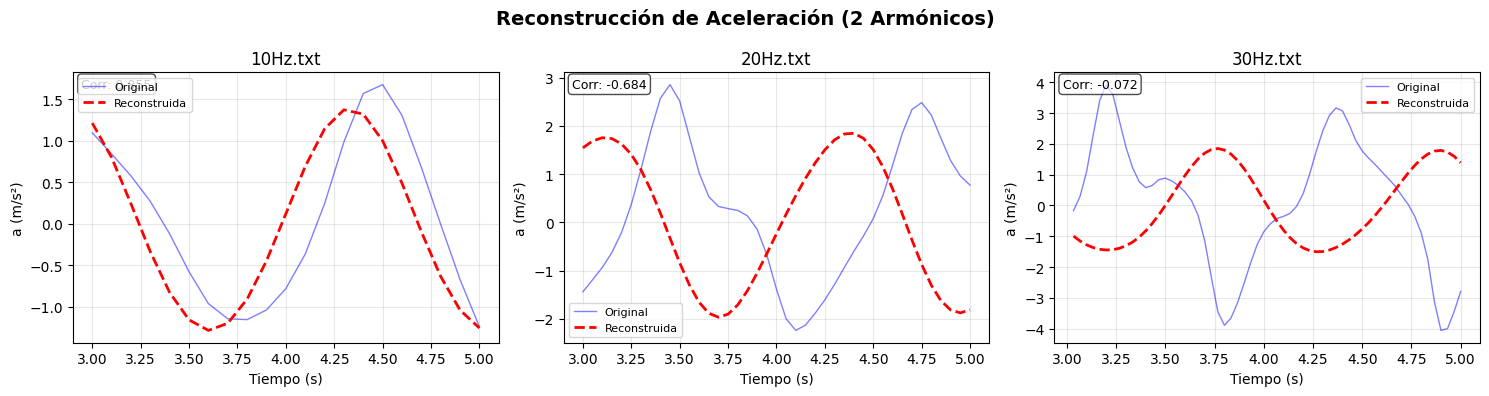

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Reconstrucción de Aceleración (2 Armónicos)', fontsize=14, fontweight='bold')

for i, (archivo, datos) in enumerate(resultados.items()):
    # Mostrar primeros 5 segundos o todos los datos
    limit_t = min(datos['t'][-1], 5.0)
    mask = datos['t'] <= limit_t

    axes[i].plot(datos['t'][mask], datos['a'][mask], 'b-', alpha=0.5, linewidth=1, label='Original')
    axes[i].plot(datos['t'][mask], datos['a_reconst'][mask], 'r--', linewidth=2, label='Reconstruida')
    axes[i].set_xlabel('Tiempo (s)')
    axes[i].set_ylabel('a (m/s²)')
    axes[i].set_title(archivo)
    axes[i].legend(fontsize=8)
    axes[i].grid(True, alpha=0.3)

    # Mostrar correlación
    corr_text = f'Corr: {datos["correlacion"]:.3f}'
    axes[i].text(0.02, 0.98, corr_text, transform=axes[i].transAxes, va='top',
                 fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

### Evaluación de la Reconstrucción

Análisis de qué información se conserva y qué se pierde al usar solo 2 armónicos.

## 13. Resumen de Resultados

Tabla comparativa con los parámetros principales obtenidos.

In [13]:
# Crear tabla resumen
print("="*80)
print(f"{'RESUMEN DE RESULTADOS':^80}")
print("="*80)
print(f"\n{'Archivo':<15} {'A (m)':<10} {'ω (rad/s)':<12} {'f₁ (Hz)':<10} {'f₂ (Hz)':<10} {'f₂/f₁':<8} {'Corr.':<8}")
print("-"*80)

for archivo, datos in resultados.items():
    A = datos['A']
    w = datos['w']
    f1 = datos['armonicos'][0][0] if len(datos['armonicos']) > 0 else 0
    f2 = datos['armonicos'][1][0] if len(datos['armonicos']) > 1 else 0
    relacion = f2/f1 if f1 != 0 else 0
    corr = datos['correlacion']

    print(f"{archivo:<15} {A:<10.4f} {w:<12.4f} {f1:<10.3f} {f2:<10.3f} {relacion:<8.2f} {corr:<8.3f}")

print("="*80)

# Interpretación
print("\nINTERPRETACIÓN:")
for archivo, datos in resultados.items():
    w_mean = np.mean(datos['w_ang'])
    w_std = np.std(datos['w_ang'])
    var_pct = (w_std / abs(w_mean)) * 100 if w_mean != 0 else 0

    f1 = datos['armonicos'][0][0] if len(datos['armonicos']) > 0 else 0
    f2 = datos['armonicos'][1][0] if len(datos['armonicos']) > 1 else 0
    relacion = f2/f1 if f1 != 0 else 0

    print(f"\n{archivo}:")
    print(f"  • MCU: {'✓ Aproximado' if var_pct < 10 else '✗ No uniforme'} (variación={var_pct:.1f}%)")
    print(f"  • Segundo armónico: {'✓ Confirmado' if 1.8 < relacion < 2.2 else '⚠ Atípico'} (f₂/f₁={relacion:.2f})")
    print(f"  • Reconstrucción: {'✓ Excelente' if datos['correlacion'] > 0.95 else '✓ Buena' if datos['correlacion'] > 0.85 else '⚠ Regular'}")

print("\n" + "="*80)

                             RESUMEN DE RESULTADOS                              

Archivo         A (m)      ω (rad/s)    f₁ (Hz)    f₂ (Hz)    f₂/f₁    Corr.   
--------------------------------------------------------------------------------
10Hz.txt        -0.0876    4.3521       0.693      1.386      2.00     0.855   
20Hz.txt        0.0888     4.8874       0.796      1.692      2.12     -0.684  
30Hz.txt        0.0866     5.3718       0.900      1.700      1.89     -0.072  

INTERPRETACIÓN:

10Hz.txt:
  • MCU: ✗ No uniforme (variación=14.3%)
  • Segundo armónico: ✓ Confirmado (f₂/f₁=2.00)
  • Reconstrucción: ✓ Buena

20Hz.txt:
  • MCU: ✗ No uniforme (variación=15.2%)
  • Segundo armónico: ✓ Confirmado (f₂/f₁=2.12)
  • Reconstrucción: ⚠ Regular

30Hz.txt:
  • MCU: ✗ No uniforme (variación=17.8%)
  • Segundo armónico: ✓ Confirmado (f₂/f₁=1.89)
  • Reconstrucción: ⚠ Regular



In [14]:
print("="*80)
print("ANÁLISIS DEL MOVIMIENTO CIRCULAR UNIFORME (MCU)")
print("="*80)

for archivo, datos in resultados.items():
    print(f"\n{archivo}:")

    # Análisis de velocidad angular
    w_mean = np.mean(datos['w_ang'])
    w_std = np.std(datos['w_ang'])
    w_max = np.max(datos['w_ang'])
    w_min = np.min(datos['w_ang'])
    var_pct = (w_std / abs(w_mean)) * 100 if w_mean != 0 else 0

    print(f"\n  Velocidad angular:")
    print(f"    • Promedio: {w_mean:.4f} rad/s")
    print(f"    • Rango: [{w_min:.4f}, {w_max:.4f}] rad/s")
    print(f"    • Desviación: {w_std:.4f} rad/s ({var_pct:.2f}%)")

    # Análisis de aceleración angular
    alpha = datos['alpha']
    alpha_pos = alpha[alpha > 0]
    alpha_neg = alpha[alpha < 0]
    t_pos = len(alpha_pos) / len(alpha) * 100
    t_neg = len(alpha_neg) / len(alpha) * 100

    print(f"\n  Aceleración angular:")
    print(f"    • Intervalos positivos (acelerando): {t_pos:.1f}% del tiempo")
    print(f"    • Intervalos negativos (desacelerando): {t_neg:.1f}% del tiempo")
    print(f"    • Amplitud media positiva: {np.mean(alpha_pos):.4f} rad/s²" if len(alpha_pos) > 0 else "")
    print(f"    • Amplitud media negativa: {np.mean(alpha_neg):.4f} rad/s²" if len(alpha_neg) > 0 else "")

    # Conclusión sobre MCU
    print(f"\n  Conclusión:")
    if var_pct < 5:
        print(f"    ✓ EXCELENTE aproximación a MCU (variación < 5%)")
    elif var_pct < 10:
        print(f"    ✓ BUENA aproximación a MCU (variación < 10%)")
    else:
        print(f"    ✗ NO se aproxima a MCU (alta variación: {var_pct:.1f}%)")

    # Explicación de aceleraciones
    if abs(t_pos - t_neg) < 10:
        print(f"    • Aceleraciones equilibradas: intento de mantener velocidad constante")
    elif t_pos > t_neg + 10:
        print(f"    • Predominan aceleraciones: tendencia a aumentar velocidad")
    else:
        print(f"    • Predominan desaceleraciones: tendencia a reducir velocidad")

print("\n" + "="*80)

ANÁLISIS DEL MOVIMIENTO CIRCULAR UNIFORME (MCU)

10Hz.txt:

  Velocidad angular:
    • Promedio: 4.3412 rad/s
    • Rango: [2.9574, 5.5996] rad/s
    • Desviación: 0.6213 rad/s (14.31%)

  Aceleración angular:
    • Intervalos positivos (acelerando): 47.5% del tiempo
    • Intervalos negativos (desacelerando): 52.5% del tiempo
    • Amplitud media positiva: 2.3970 rad/s²
    • Amplitud media negativa: -1.9985 rad/s²

  Conclusión:
    ✗ NO se aproxima a MCU (alta variación: 14.3%)
    • Aceleraciones equilibradas: intento de mantener velocidad constante

20Hz.txt:

  Velocidad angular:
    • Promedio: 4.9027 rad/s
    • Rango: [3.5197, 6.8844] rad/s
    • Desviación: 0.7428 rad/s (15.15%)

  Aceleración angular:
    • Intervalos positivos (acelerando): 48.8% del tiempo
    • Intervalos negativos (desacelerando): 51.2% del tiempo
    • Amplitud media positiva: 4.6625 rad/s²
    • Amplitud media negativa: -4.3128 rad/s²

  Conclusión:
    ✗ NO se aproxima a MCU (alta variación: 15.2%)
  

In [15]:
print("="*80)
print("ANÁLISIS DE x(θ): RELACIÓN POSICIÓN-ÁNGULO")
print("="*80)

for archivo, datos in resultados.items():
    print(f"\n{archivo}:")

    x = datos['x']
    theta = datos['theta']

    # Análisis de simetría
    x_max = np.max(x)
    x_min = np.min(x)
    x_rango = x_max - x_min

    print(f"\n  Características:")
    print(f"    • Posición máxima: {x_max:.4f} m")
    print(f"    • Posición mínima: {x_min:.4f} m")
    print(f"    • Rango de movimiento: {x_rango:.4f} m")

    # Verificar comportamiento sinusoidal
    if datos['error_rms_theta'] is not None:
        error_pct = (datos['error_rms_theta'] / x_rango) * 100
        print(f"\n  Ajuste sinusoidal x(θ) = A₀ + A·cos(θ + φ):")
        print(f"    • Error RMS: {datos['error_rms_theta']:.5f} m")
        print(f"    • Error relativo: {error_pct:.2f}% del rango")

        if error_pct < 2:
            print(f"    ✓ Comportamiento APROXIMADAMENTE sinusoidal")
        else:
            print(f"    ✗ Desviaciones significativas del comportamiento sinusoidal")

    # Análisis de asimetrías
    mitad = len(x) // 2
    x_primera = x[:mitad]
    x_segunda = x[mitad:]
    asimetria = abs(np.mean(x_primera) - np.mean(x_segunda))

    print(f"\n  Asimetrías detectadas:")
    print(f"    • Diferencia entre mitades: {asimetria:.5f} m")

    if asimetria < 0.005:
        print(f"    ✓ Movimiento simétrico")
    else:
        print(f"    ⚠ Asimetría presente")

    # Explicación física
    print(f"\n  Interpretación geométrica:")
    print(f"    La longitud finita de la biela (l) introduce componentes anarmónicos.")
    print(f"    Esto genera:")
    print(f"      • Asimetrías entre compresión y expansión del pistón")
    print(f"      • Velocidades diferentes en los extremos del recorrido")
    print(f"      • Aparición del segundo armónico (frecuencia 2f)")
    print(f"    ")
    print(f"    Modelo teórico: x(θ) ≈ l - r²/4l + r·cos(θ) - (r²/4l)·cos(2θ)")
    print(f"                         └─ offset ─┘  └─ 1er arm. ─┘  └─ 2do arm. ─┘")

print("\n" + "="*80)

ANÁLISIS DE x(θ): RELACIÓN POSICIÓN-ÁNGULO

10Hz.txt:

  Características:
    • Posición máxima: 0.5133 m
    • Posición mínima: 0.3289 m
    • Rango de movimiento: 0.1844 m

  Ajuste sinusoidal x(θ) = A₀ + A·cos(θ + φ):
    • Error RMS: 0.00441 m
    • Error relativo: 2.39% del rango
    ✗ Desviaciones significativas del comportamiento sinusoidal

  Asimetrías detectadas:
    • Diferencia entre mitades: 0.00011 m
    ✓ Movimiento simétrico

  Interpretación geométrica:
    La longitud finita de la biela (l) introduce componentes anarmónicos.
    Esto genera:
      • Asimetrías entre compresión y expansión del pistón
      • Velocidades diferentes en los extremos del recorrido
      • Aparición del segundo armónico (frecuencia 2f)
    
    Modelo teórico: x(θ) ≈ l - r²/4l + r·cos(θ) - (r²/4l)·cos(2θ)
                         └─ offset ─┘  └─ 1er arm. ─┘  └─ 2do arm. ─┘

20Hz.txt:

  Características:
    • Posición máxima: 0.5124 m
    • Posición mínima: 0.3267 m
    • Rango de movimien

In [16]:
print("="*80)
print("ANÁLISIS ESPECTRAL DETALLADO - ARMÓNICOS")
print("="*80)

for archivo, datos in resultados.items():
    print(f"\n{archivo}:")

    # Armónicos dominantes
    armonicos = datos['armonicos']
    print(f"\n  Armónicos dominantes (2 principales):")
    for i, (freq, amp, fase) in enumerate(armonicos, 1):
        print(f"    Armónico {i}: f={freq:.3f} Hz, A={amp:.4f} m/s², φ={fase:.3f} rad")

    # Verificar segundo armónico
    if len(armonicos) >= 2:
        f1, A1, phi1 = armonicos[0]
        f2, A2, phi2 = armonicos[1]
        relacion = f2 / f1 if f1 != 0 else 0
        ratio_amp = A2 / A1 if A1 != 0 else 0

        print(f"\n  Relación entre armónicos:")
        print(f"    • f₂/f₁ = {relacion:.3f}")
        print(f"    • A₂/A₁ = {ratio_amp:.3f} ({ratio_amp*100:.1f}%)")

        if 1.8 < relacion < 2.2:
            print(f"    ✓ Se confirma el SEGUNDO ARMÓNICO (f₂ ≈ 2f₁)")
            print(f"      Causa: Geometría de la biela-manivela (longitud finita de biela)")
        else:
            print(f"    ⚠ Relación atípica - posible ruido o armónico diferente")

    # Buscar armónicos adicionales
    xf = datos['xf']
    amplitudes = datos['amplitudes']
    amp_threshold = 0.1 * np.max(amplitudes)  # 10% del máximo

    # Encontrar todos los picos significativos
    picos_adicionales = []
    for i, amp in enumerate(amplitudes):
        if i > 0 and amp > amp_threshold:  # Ignorar DC
            # Verificar si es un pico local
            if i > 0 and i < len(amplitudes)-1:
                if amplitudes[i] > amplitudes[i-1] and amplitudes[i] > amplitudes[i+1]:
                    if i not in datos['idx_peaks']:  # No es uno de los 2 principales
                        picos_adicionales.append((xf[i], amp))

    if picos_adicionales:
        print(f"\n  Armónicos adicionales detectados ({len(picos_adicionales)}):")
        for freq, amp in picos_adicionales[:3]:  # Mostrar máximo 3
            print(f"    • f={freq:.3f} Hz, A={amp:.4f} m/s²")

        print(f"\n  Posibles causas de armónicos adicionales:")
        print(f"    • Fricción no lineal en el sistema")
        print(f"    • Holguras en las articulaciones (biela-manivela, biela-pistón)")
        print(f"    • Vibraciones mecánicas del riel o estructura")
        print(f"    • Ruido en el sensor de medición")
        print(f"    • Variaciones en la velocidad angular (no-MCU perfecto)")
    else:
        print(f"\n  No se detectaron armónicos adicionales significativos")
        print(f"  ✓ El sistema se comporta principalmente con 2 armónicos")

print("\n" + "="*80)

ANÁLISIS ESPECTRAL DETALLADO - ARMÓNICOS

10Hz.txt:

  Armónicos dominantes (2 principales):
    Armónico 1: f=0.693 Hz, A=1.3378 m/s², φ=-0.013 rad
    Armónico 2: f=1.386 Hz, A=0.0506 m/s², φ=-0.054 rad

  Relación entre armónicos:
    • f₂/f₁ = 2.000
    • A₂/A₁ = 0.038 (3.8%)
    ✓ Se confirma el SEGUNDO ARMÓNICO (f₂ ≈ 2f₁)
      Causa: Geometría de la biela-manivela (longitud finita de biela)

  Armónicos adicionales detectados (1):
    • f=1.089 Hz, A=0.2501 m/s²

  Posibles causas de armónicos adicionales:
    • Fricción no lineal en el sistema
    • Holguras en las articulaciones (biela-manivela, biela-pistón)
    • Vibraciones mecánicas del riel o estructura
    • Ruido en el sensor de medición
    • Variaciones en la velocidad angular (no-MCU perfecto)

20Hz.txt:

  Armónicos dominantes (2 principales):
    Armónico 1: f=0.796 Hz, A=1.8721 m/s², φ=-2.912 rad
    Armónico 2: f=1.692 Hz, A=0.1374 m/s², φ=2.171 rad

  Relación entre armónicos:
    • f₂/f₁ = 2.125
    • A₂/A₁ = 0

In [17]:
print("="*80)
print("CALIDAD DE LA RECONSTRUCCIÓN CON 2 ARMÓNICOS")
print("="*80)

for archivo, datos in resultados.items():
    print(f"\n{archivo}:")

    a_orig = datos['a']
    a_recon = datos['a_reconst']

    # Métricas de calidad
    correlacion = datos['correlacion']
    error = a_orig - a_recon
    error_rms = np.sqrt(np.mean(error**2))
    error_max = np.max(np.abs(error))
    energia_orig = np.sum(a_orig**2)
    energia_recon = np.sum(a_recon**2)
    energia_conservada = (energia_recon / energia_orig) * 100 if energia_orig != 0 else 0

    print(f"\n  Métricas de aproximación:")
    print(f"    • Correlación: {correlacion:.4f}")
    print(f"    • Error RMS: {error_rms:.5f} m/s²")
    print(f"    • Error máximo: {error_max:.5f} m/s²")
    print(f"    • Energía conservada: {energia_conservada:.1f}%")

    # Clasificación de calidad
    print(f"\n  Evaluación:")
    if correlacion > 0.95:
        print(f"    ✓ EXCELENTE reconstrucción")
        print(f"      → Los 2 armónicos capturan >95% de la señal")
    elif correlacion > 0.85:
        print(f"    ✓ BUENA reconstrucción")
        print(f"      → Los 2 armónicos capturan la dinámica principal")
    elif correlacion > 0.75:
        print(f"    ⚠ REGULAR reconstrucción")
        print(f"      → Se pierden componentes importantes")
    else:
        print(f"    ✗ POBRE reconstrucción")
        print(f"      → Se requieren más armónicos")

    # Análisis de lo que se conserva
    print(f"\n  Información CONSERVADA:")
    print(f"    • Frecuencia fundamental del movimiento")
    print(f"    • Asimetría debido a la geometría (2do armónico)")
    print(f"    • Forma de onda general y periodicidad")
    print(f"    • {energia_conservada:.1f}% de la energía total de la señal")

    # Análisis de lo que se pierde
    print(f"\n  Información PERDIDA:")
    if correlacion < 0.95:
        print(f"    • Armónicos superiores (3er, 4to, etc.)")
        print(f"    • Detalles finos de las transiciones")
        print(f"    • Componentes de ruido y vibraciones")
        print(f"    • Efectos no lineales de alta frecuencia")
    else:
        print(f"    • Mínima (ruido y componentes despreciables)")

    # Interpretación física
    print(f"\n  Significado físico:")
    if correlacion > 0.90:
        print(f"    El sistema biela-manivela se describe BIEN con:")
        print(f"    • Componente principal (MAS ideal)")
        print(f"    • Corrección del 2do armónico (efecto geométrico)")
        print(f"    • Otros efectos son despreciables")
    else:
        print(f"    Se requieren armónicos adicionales para modelar:")
        print(f"    • Fricción variable")
        print(f"    • No linealidades del sistema")
        print(f"    • Efectos dinámicos complejos")

print("\n" + "="*80)
print("\nNOTA IMPORTANTE:")
print("Para DFT óptima, se recomienda seleccionar un intervalo donde la señal")
print("sea aproximadamente periódica (primeros 5 segundos en las gráficas).")
print("="*80)

CALIDAD DE LA RECONSTRUCCIÓN CON 2 ARMÓNICOS

10Hz.txt:

  Métricas de aproximación:
    • Correlación: 0.8547
    • Error RMS: 0.51805 m/s²
    • Error máximo: 1.05716 m/s²
    • Energía conservada: 94.7%

  Evaluación:
    ✓ BUENA reconstrucción
      → Los 2 armónicos capturan la dinámica principal

  Información CONSERVADA:
    • Frecuencia fundamental del movimiento
    • Asimetría debido a la geometría (2do armónico)
    • Forma de onda general y periodicidad
    • 94.7% de la energía total de la señal

  Información PERDIDA:
    • Armónicos superiores (3er, 4to, etc.)
    • Detalles finos de las transiciones
    • Componentes de ruido y vibraciones
    • Efectos no lineales de alta frecuencia

  Significado físico:
    Se requieren armónicos adicionales para modelar:
    • Fricción variable
    • No linealidades del sistema
    • Efectos dinámicos complejos

20Hz.txt:

  Métricas de aproximación:
    • Correlación: -0.6843
    • Error RMS: 2.56079 m/s²
    • Error máximo: 4.4413